# Final Project Title Here
### Subtitle Here

Mark Keller<br>
CMSC320<br>
Final Tutorial Project<br>
29 November 2018

#### Table of Contents
1. [Introduction](#introduction)
2. [Data](#data)
3. Exploration
4. Regression Analysis
5. Classification Analysis
6. Conclusions
7. Caveats


## Introduction

For the past few weeks, the Camp Fire in Northern California has been a deadly and destructive force, recieving enormous media coverage. 
This deadly wildfire that began on November 8, 2018 has left [85 people dead, 249 missing, and destroyed thousands of buildings](https://www.usatoday.com/story/news/nation/2018/11/25/california-wildfire-camp-fire-contained/2107829002/).
It has resulted in major air quality issues, causing many to [wear masks](https://www.washingtonpost.com/nation/2018/11/17/behold-latest-sign-apocalypse-air-mask-selfies-fire-ravaged-california/?utm_term=.fe6d94c1991f) or [stay indoors](https://www.wired.com/story/smoke-from-wildfires-is-a-growing-public-health-crisis-for-cities/) to protect their health.
But this is not the first time a major wildfire has ravaged the west coast of the United States.

In this tutorial, we will analyze west coast wildfire data from 2010 to 2016, available through the University of California Irvine Data Science Initiative GitHub organization [here](https://github.com/UCIDataScienceInitiative/Climate_Hackathon/tree/master/west_coast_fires). This data has been obtained through the NASA [Moderate Resolution Imaging Spectroradiometer](https://en.wikipedia.org/wiki/Moderate_Resolution_Imaging_Spectroradiometer) (MODIS) satellite. We will begin by loading the data and performing exploratory data analysis before diving deeper into regression analysis and classification analysis using basic machine learning methods. These data science methods will allow us to look at past trends and make inferences about future west coast wildfires.

## Data

We will begin by importing Python packages that will help us to load and wrangle the data:
- `pandas`: a package that allows us to build data frames, a tabular data format that can be thought of like a spreadsheet
- `numpy`: a package containing matrix and vector mathematical functions

In [2]:
import pandas as pd
import numpy as np

The wildfire dataset is contained in a comma-separated values file (CSV) located on GitHub. Pandas has a `read_csv` function that allows us to load a data frame from a CSV over the web. We will specify the data types of each column using a python `dict` to ensure that pandas loads the data using the data types that we will want to use in our analysis.

In [6]:
data_url = 'https://raw.githubusercontent.com/UCIDataScienceInitiative/Climate_Hackathon/master/west_coast_fires/fires.csv'
dtype = {
    'confidence': float,
    'day': int,
    'frp': float,
    'lat': float,
    'lon': float,
    'month': int,
    'year': int,
    'x': float,
    'y': float,
    'dayofyear': int,
    'vdp': float,
    'temp': float,
    'humidity': float
}
df = pd.read_csv(data_url, index_col=0, dtype=dtype)
df.head()

,confidence,day,frp,lat,lon,month,year,x,y,dayofyear,vpd,temp,humidity
id,,,,,,,,,,,,,
10122,0.61,1,6.0,32.997,-110.765,1,2010,1336.853783,110.667,0,0.232254,271.10,55.8
10123,0.72,1,11.1,32.995,-110.777,1,2010,1335.747633,110.445,0,0.232254,271.10,55.8
13460,0.57,2,6.3,33.650,-113.735,1,2010,1056.936097,183.150,1,0.333371,272.70,43.6
13461,0.62,2,10.2,32.358,-114.922,1,2010,950.464277,39.738,1,0.158511,274.70,76.8
22139,0.56,3,14.4,33.415,-110.860,1,2010,1325.030866,157.065,2,0.159304,268.62,63.5


The next step is to determine what this wildfire data means so that we can perform exploration. 
Luckily, the [README](https://github.com/UCIDataScienceInitiative/Climate_Hackathon/blob/master/west_coast_fires/README.md) for the GitHub repository provides us with a description of each column:

- `id`: unique identifier of the fire in the overall context of the world dataset
- `confidence`: how much confidence the satellite has that this is actually a fire detection (percent)
- `day`: the day of the month
- `frp`: Fire Radiative Power, the strength of the fire
- `lat`: latitude
- `lon`: longitude
- `month`: month of the year
- `year`: year
- `x`: x position in a uniformly-spaced grid
- `y`: y position in a uniformly-spaced grid
- `dayofyear`: day of the year (from 0 to 364 or 365 for leap years)
- `vpd`: [Vapor Pressure Deficit](https://en.wikipedia.org/wiki/Vapour-pressure_deficit), the difference between the moisture in the air and the amount of moisture the air could hold
- `temp`: temperature (degrees Kelvin)
- `humidity`: humidity (percent)


## Exploration

To begin our exploration, we can look at the distributions of some of our variables. 

To visualize data, we can load helpful python visualization packages:
- `matplotlib`
- `seaborn`

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

/Users/markkeller/miniconda3/envs/cmsc320/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


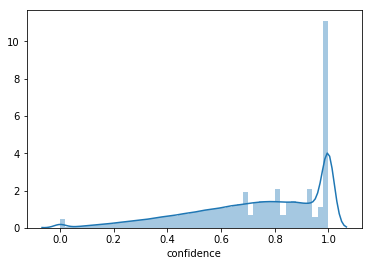

In [10]:
sns.distplot(df['confidence'])